In [2]:
##############  Advanced Machine Learning 
##############  Assignemet 1
##############  Artificial Neural Network using Numpy (CIFAR 10 dataset)

## I have created multiple functions for different tasks. I havent used Class model. For data loading I am using the instructions given on  https://www.cs.toronto.edu/~kriz/cifar.html 


## Data set and test set creation using pickle and numpy

In [3]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
dict1 = unpickle('data_batch_1')
dict2 = unpickle('data_batch_2')
dict3 = unpickle('data_batch_3')
dict4 = unpickle('data_batch_4')
dict5 = unpickle('data_batch_5')
dict6 = unpickle('test_batch')

labels1 = dict1.get(b'labels')
labels1 = np.array(labels1)
labels2 = dict2.get(b'labels')
labels2 = np.array(labels2)
labels3 = dict3.get(b'labels')
labels3 = np.array(labels3)
labels4 = dict4.get(b'labels')
labels4 = np.array(labels4)
labels5 = dict5.get(b'labels')
labels5 = np.array(labels5)
labels6 = dict6.get(b'labels')
labels6 = np.array(labels6)

data1 = dict1.get(b'data')
data1 = np.array(data1)
data2 = dict2.get(b'data')
data2 = np.array(data2)
data3 = dict3.get(b'data')
data3 = np.array(data3)
data4 = dict4.get(b'data')
data4 = np.array(data4)
data5 = dict5.get(b'data')
data5 = np.array(data5)
data6 = dict6.get(b'data')
data6 = np.array(data6)

## Function that accepts images, labels, lebels of objects 1,2 and reutrns normalized images and one hot labels

In [5]:
def two_objects_two_labels(data, labels, l1, l2):
    " data :  numpy array of images unpickled from given files "
    " labels: numpy array of labels unpickled from given files "
    " l1:     label of first object"
    " l2:     label of second object"
    indices_label0 = np.nonzero(labels == l1)
    indices_label1 = np.nonzero(labels == l2)
    a = np.array(np.nonzero(labels == l1))
    b = np.array(np.nonzero(labels == l2))
    c = np.concatenate((a,b), axis = 1).flatten()
    np.random.shuffle(c)
    x = data[c]
    y = labels[c]
    y = np.where(y==l1, 0, y)
    y = np.where(y==l2, 1, y)
    y_neat = y.reshape(1,len(y))
    yhot = np.zeros((len(y),2))
    
    x = x/255
    x = (x - np.mean(x))/np.std(x)

    for i in range(len(y)):
        yhot[i][y_neat.astype(int)[:,i]-1] = 1
        
    y = yhot
    return x,y

In [6]:
### Extracting all the images and labels using above function 
x1, y1 = two_objects_two_labels(data1, labels1 , 0, 1)
x2, y2 = two_objects_two_labels(data2, labels2 , 0, 1)
x3, y3 = two_objects_two_labels(data3, labels3 , 0, 1)
x4, y4 = two_objects_two_labels(data4, labels4 , 0, 1)
x5, y5 = two_objects_two_labels(data5, labels5 , 0, 1)

## As we have X and Y ( images and labels ) in required form, we are spliting them as train and test data

In [7]:
X_train = np.concatenate((x1,x2,x3,x4,x5), axis= 0)

In [8]:
Y_train = np.concatenate((y1,y2,y3,y4,y5), axis=0)

In [9]:
x6, y6 = two_objects_two_labels(data6, labels6 , 0, 1)

In [10]:
X_test = x6

In [11]:
Y_test = y6

## Defining ReLU and Softmax function

In [12]:
def relu_der(x):
    return (x>=0)

def relu(x):
    return np.maximum(0,x)

def softmax(x):
    x = np.maximum(-700,np.minimum(700,x))           ### I have basically clipped the incoming input to the softmax
    temp = np.exp(x - np.max(x))                     ### between  + e^700  and - e^700 because output from previous
    return temp/ temp.sum(axis=1, keepdims=True)     ### layers was jumping above max level

## I am going to initialize the weights and biases of the layers. The information about the layers is taken from the dictionary. This dictionary contains architecture of our ANN, which can be modified according to the need. The following function initalizes the weights and biases according to the architecture and return the parameter values

In [13]:
def init_layers(nn_architecture):

    number_of_layers = len(nn_architecture)
    params_values = {}

    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        params_values['W' + str(layer_idx)] =  0.2 * np.random.random((layer_input_size, layer_output_size)) * 0.1
        params_values['b' + str(layer_idx)] =  0.2 * np.random.random(layer_output_size) * 0.1
        
    return params_values

## I am going to define now a new function which does forward propagation for a single layer and return activated outputs and outputs.

In [14]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation):
    " A_perv: input from previous layer"
    " W_curr: weightd of the current layer"
    " b_curr: biases of the current layer"
    " activation: activation function that we want to use in the current layer"
    
    Z_curr = np.dot(A_prev, W_curr) + b_curr
    
    if activation is "relu":
        activation_func = relu
    elif activation is "softmax":
        activation_func = softmax
    else:
        raise Exception('Check Activation Function!!!')
        
    return activation_func(Z_curr), Z_curr

## Now we will design a function for full forward propagation. This function accepts the input images, parameter values and ANN architecture in form of dictionary. It return output after forward propagation at the end of the layers and memory which a dictionary that stores activations of the specific layer and input to those activations

In [15]:
def full_forward_propagation(X, params_values, nn_architecture):
    " X: Input images as numpy array "
    " params_values: dictionary of parameters that we created in the first function"
    " nn_architecture: dictionay that contains input neurons, output neurons and activation function "
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr
        
        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

## As we are done with the forward propagation, now we have a memory that contains activations of each layer and input to each activations. We also have the parameters which needs to be updated according to the gradients. This is done using following function named full_backward_propagation. This function will create a dictionary of gradients which are calculated for each layer whether it is ReLU or the last Softmax layer

In [16]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    "   Y_hat       :  the predicted output from forward propagation"
    "     Y         :  the expected output"
    "   memory      :  the dictionary that was created previously containing activations and input to them"
    "params_values  :  the dictionary that was created previously containing weights and biases"
    "nn_architecture:  the dictionary that contains number of input, output neurons and activation function of each layer"
    grads_values = {}
    m = Y.shape[1]

    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        if activ_function_curr is "softmax":
            delta = Y_hat - Y
            dW_curr = np.dot(A_prev.T,delta)
            db_curr = delta.sum(axis=0)/m
        elif activ_function_curr is "relu":
            W_curr = params_values["W" + str(layer_idx_curr+1)]
            delta = np.dot(delta, W_curr.T) * relu_der(Z_curr)
            dW_curr = np.dot(A_prev.T, delta)
            db_curr = delta.sum(axis=0)/m
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

## After backprop, we will get gradients which are stored. Now, we use them to update the weights and overwrite the updated weights and biases. The funtion returns the updated parameters  

In [17]:
def update(params_values, grads_values, nn_architecture, learning_rate):
    "params_values  : the dictionary of parameters "
    "grads_values   : the dictionary of gradients"
    "nn_architecture: the dictionary that contains number of input, output neurons and activation function of each layer"
    "learning_rate  : the learning rate to be used to update the parameters"
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values

## Now its time to build a train function. We have to give images, labels, learning rate, epochs, batch size and neural network actitecture. It will print training accuracy, loss for each epoch. It will plot our loss also. It returns trained parameters, loss per epoch and dictionary of memory.

In [18]:
def train(x_train1, y_train1, learning_rate, epochs, batch_size, nn_architecture2):    
    "x_train1        : images "
    "y_train1        : labels "
    "learning_rate   : weights used for upadating weights"
    "epochs          : number of times all images trained"
    "batch_size      : batch size for stochastic gradient descent"
    "nn_architecture2: architecture of neural network in form of dictionary"
    loss_history = []
    loss_per_epoch = np.zeros((epochs,1))
    train_data_len = len(y_train1)
    params_values4 = init_layers(nn_architecture2)
    for j in range(epochs):
        for i in range(int(train_data_len/batch_size)):
            batch_start =  i*batch_size
            batch_end = (i+1)*batch_size
            x_trainb = x_train1[batch_start:batch_end]
            y_trainb = y_train1[batch_start:batch_end]
            A_prev5, memory5 = full_forward_propagation(x_trainb, params_values4, nn_architecture2)
            grads_values4 = full_backward_propagation(A_prev5, y_trainb, memory5, params_values4, nn_architecture2)
            params_values4 = update(params_values4, grads_values4, nn_architecture2, learning_rate)
            A_prev5 = np.maximum(0.000000001,np.minimum(0.99999999999,A_prev5))
            losss = np.sum(-y_trainb * np.log(A_prev5 + 1e-8))
            loss_history.append(losss)
        
        losss_array = np.array(loss_history)
        loss_per_epoch[j] = np.mean(losss_array)
        loss_history = []
        A_prev6, memory6 = full_forward_propagation(x_train1, params_values4, nn_architecture2)        
        print('Epoch number = ' + str(j+1))
        print('Loss function value: ', loss_per_epoch[j])
        print('\n')
    count = 0
    for k in range(len(y_train1)):
        if(np.argmax(y_train1[k])==np.argmax(A_prev6[k])):
            count += 1

    correct_pred = (count/len(y_train1))*100
    print('\n')
    print('\n')
    print('Training accuracy: ' + str(correct_pred))
    print('\n')
    print('\n')
        
    yy = loss_per_epoch
    xx = np.arange(1,epochs+1)
    plt.plot(xx,yy)
    plt.title('CIFAR 10 binary classification Training Loss vs Number of Epochs')
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    
    return params_values4, loss_per_epoch, memory6

## After training we need to validate our model. So I have written a function which uses full_forward_propagation function to predict the output. It take test data, its labels, parameters which were tunned while training and dictionary that contains about neural network arhitecture. It return the predictions along with the memory.

In [19]:
def test(X_test, Y_test, params_values, nn_architecture):
    "X_test       : Test data"
    "Y_test       : Test labels"
    "params_values: dictionary of parameters"
    "nn_architecture: dictionary providing information about the network"
    prediction, memory = full_forward_propagation(X_test, params_values, nn_architecture)
    count = 0
    for k in range(len(Y_test)):
        if(np.argmax(Y_test[k])==np.argmax(prediction[k])):
            count += 1

    correct_pred = (count/len(Y_test))*100
    print('\n')
    print('\n')
    print('Test accuracy: ' + str(correct_pred))
    print('\n')
    print('\n')
    return prediction, memory

## Now its time to define how our network looks! I have created a dictionary that is of below format. It has input dimension

In [21]:
nn_architecture2 = [
    {"input_dim": 3072, "output_dim": 500, "activation": "relu"},
#     {"input_dim": 500, "output_dim": 100, "activation": "relu"},
#      {"input_dim": 100, "output_dim": 50, "activation": "relu"},
#     {"input_dim": 60, "output_dim": 40, "activation": "relu"},
    {"input_dim": 500, "output_dim": 2, "activation": "softmax"},
]

## Our model is going to train now. I have set learning rate as 0.001, 1000 epochs and batch size of 10. We will get loss per epoch printed and at the end of 1000 epochs we will get the training accuracy and plot of loss.

Epoch number = 1
Loss function value:  [15.21504957]


Epoch number = 2
Loss function value:  [6.64256062]


Epoch number = 3
Loss function value:  [5.13349643]


Epoch number = 4
Loss function value:  [4.33707907]


Epoch number = 5
Loss function value:  [3.85099546]


Epoch number = 6
Loss function value:  [3.42937159]


Epoch number = 7
Loss function value:  [3.14334572]


Epoch number = 8
Loss function value:  [2.93858452]


Epoch number = 9
Loss function value:  [2.72274809]


Epoch number = 10
Loss function value:  [2.48563267]


Epoch number = 11
Loss function value:  [2.36245194]


Epoch number = 12
Loss function value:  [2.1877587]


Epoch number = 13
Loss function value:  [2.09631324]


Epoch number = 14
Loss function value:  [1.97804929]


Epoch number = 15
Loss function value:  [1.8265085]


Epoch number = 16
Loss function value:  [1.67024961]


Epoch number = 17
Loss function value:  [1.57150611]


Epoch number = 18
Loss function value:  [1.48239016]


Epoch number = 19
Lo

Epoch number = 150
Loss function value:  [0.01063545]


Epoch number = 151
Loss function value:  [0.01054954]


Epoch number = 152
Loss function value:  [0.01048364]


Epoch number = 153
Loss function value:  [0.01043942]


Epoch number = 154
Loss function value:  [0.01039946]


Epoch number = 155
Loss function value:  [0.01035977]


Epoch number = 156
Loss function value:  [0.01032868]


Epoch number = 157
Loss function value:  [0.0102958]


Epoch number = 158
Loss function value:  [0.01025118]


Epoch number = 159
Loss function value:  [0.01025069]


Epoch number = 160
Loss function value:  [0.01020706]


Epoch number = 161
Loss function value:  [0.01017863]


Epoch number = 162
Loss function value:  [0.01015199]


Epoch number = 163
Loss function value:  [0.01012347]


Epoch number = 164
Loss function value:  [0.01078197]


Epoch number = 165
Loss function value:  [0.01100016]


Epoch number = 166
Loss function value:  [0.01012029]


Epoch number = 167
Loss function value:  [0.00999

Epoch number = 297
Loss function value:  [0.00808003]


Epoch number = 298
Loss function value:  [0.00807622]


Epoch number = 299
Loss function value:  [0.00807063]


Epoch number = 300
Loss function value:  [0.00806345]


Epoch number = 301
Loss function value:  [0.00805618]


Epoch number = 302
Loss function value:  [0.0080504]


Epoch number = 303
Loss function value:  [0.00804501]


Epoch number = 304
Loss function value:  [0.00803939]


Epoch number = 305
Loss function value:  [0.00806718]


Epoch number = 306
Loss function value:  [0.00805297]


Epoch number = 307
Loss function value:  [0.00803561]


Epoch number = 308
Loss function value:  [0.00802453]


Epoch number = 309
Loss function value:  [0.00801652]


Epoch number = 310
Loss function value:  [0.0080102]


Epoch number = 311
Loss function value:  [0.00800418]


Epoch number = 312
Loss function value:  [0.00799868]


Epoch number = 313
Loss function value:  [0.00823752]


Epoch number = 314
Loss function value:  [0.008891

Epoch number = 444
Loss function value:  [0.00754637]


Epoch number = 445
Loss function value:  [0.00754346]


Epoch number = 446
Loss function value:  [0.00754102]


Epoch number = 447
Loss function value:  [0.00753876]


Epoch number = 448
Loss function value:  [0.0075362]


Epoch number = 449
Loss function value:  [0.0075341]


Epoch number = 450
Loss function value:  [0.00753141]


Epoch number = 451
Loss function value:  [0.00755795]


Epoch number = 452
Loss function value:  [0.00755429]


Epoch number = 453
Loss function value:  [0.00754184]


Epoch number = 454
Loss function value:  [0.00753392]


Epoch number = 455
Loss function value:  [0.0075286]


Epoch number = 456
Loss function value:  [0.00752437]


Epoch number = 457
Loss function value:  [0.00752066]


Epoch number = 458
Loss function value:  [0.0075173]


Epoch number = 459
Loss function value:  [0.00751492]


Epoch number = 460
Loss function value:  [0.00751223]


Epoch number = 461
Loss function value:  [0.00750956

Epoch number = 591
Loss function value:  [0.00730074]


Epoch number = 592
Loss function value:  [0.00729946]


Epoch number = 593
Loss function value:  [0.00729806]


Epoch number = 594
Loss function value:  [0.00729671]


Epoch number = 595
Loss function value:  [0.00729555]


Epoch number = 596
Loss function value:  [0.0072943]


Epoch number = 597
Loss function value:  [0.00729309]


Epoch number = 598
Loss function value:  [0.00729179]


Epoch number = 599
Loss function value:  [0.00729051]


Epoch number = 600
Loss function value:  [0.00728932]


Epoch number = 601
Loss function value:  [0.0072882]


Epoch number = 602
Loss function value:  [0.00728695]


Epoch number = 603
Loss function value:  [0.00728583]


Epoch number = 604
Loss function value:  [0.00728452]


Epoch number = 605
Loss function value:  [0.00728335]


Epoch number = 606
Loss function value:  [0.00728218]


Epoch number = 607
Loss function value:  [0.00728103]


Epoch number = 608
Loss function value:  [0.007279

Epoch number = 738
Loss function value:  [0.00716278]


Epoch number = 739
Loss function value:  [0.00716202]


Epoch number = 740
Loss function value:  [0.00716115]


Epoch number = 741
Loss function value:  [0.0071604]


Epoch number = 742
Loss function value:  [0.00715953]


Epoch number = 743
Loss function value:  [0.00715868]


Epoch number = 744
Loss function value:  [0.00715787]


Epoch number = 745
Loss function value:  [0.00715706]


Epoch number = 746
Loss function value:  [0.00715644]


Epoch number = 747
Loss function value:  [0.00715545]


Epoch number = 748
Loss function value:  [0.00715475]


Epoch number = 749
Loss function value:  [0.00715401]


Epoch number = 750
Loss function value:  [0.00715311]


Epoch number = 751
Loss function value:  [0.00715233]


Epoch number = 752
Loss function value:  [0.00715166]


Epoch number = 753
Loss function value:  [0.00715094]


Epoch number = 754
Loss function value:  [0.00715009]


Epoch number = 755
Loss function value:  [0.00714

Epoch number = 885
Loss function value:  [0.0070719]


Epoch number = 886
Loss function value:  [0.0070714]


Epoch number = 887
Loss function value:  [0.00707098]


Epoch number = 888
Loss function value:  [0.0070704]


Epoch number = 889
Loss function value:  [0.00706995]


Epoch number = 890
Loss function value:  [0.00706949]


Epoch number = 891
Loss function value:  [0.00706895]


Epoch number = 892
Loss function value:  [0.0070685]


Epoch number = 893
Loss function value:  [0.00706803]


Epoch number = 894
Loss function value:  [0.00706762]


Epoch number = 895
Loss function value:  [0.00706702]


Epoch number = 896
Loss function value:  [0.00706652]


Epoch number = 897
Loss function value:  [0.00706607]


Epoch number = 898
Loss function value:  [0.00706561]


Epoch number = 899
Loss function value:  [0.00706518]


Epoch number = 900
Loss function value:  [0.00706797]


Epoch number = 901
Loss function value:  [0.00708018]


Epoch number = 902
Loss function value:  [0.00707475

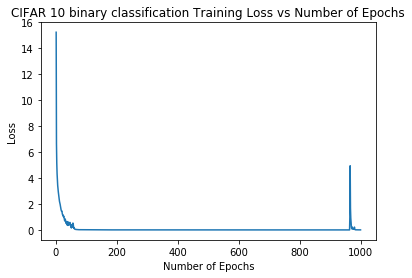

In [22]:
p, l, m = train(X_train, Y_train, 0.001, 1000, 10, nn_architecture2)

## As we have trained the model, we can see loss decreasing slowly to zero. I trained it for 1000  epochs. Loss would have decreased more as we can see down trend in loss per epoch. I got 99.98 % accuracy for training for 2 objects, aeroplane and automobile.

In [23]:
prediction, mem = test(X_test, Y_test, p, nn_architecture2)





Test accuracy: 87.94999999999999






## Our model prediced the 2 objects aeroplane and automobile with test accuracy of 87.94 %. This accuracy could have improve if our model would have learned more. As well as if we had tunned the parametes like batch size and learning rate more, but due to time contraints, we settled for this model.

In [ ]:
import numpy as np
import pandas as pd 
import torch.nn as 